In [41]:
import cv2
import torch
import numpy as np
from PIL import Image
from pytorch3d.io import load_obj
from pytorch3d.renderer.mesh import Textures
from pytorch3d.structures import Meshes
from pytorch3d.renderer.mesh.shader import ShaderBase
from pytorch3d.renderer.mesh.rasterizer import Fragments
from pytorch3d.renderer.mesh.shading import phong_shading
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras,
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer
)
from pytorch3d.ops import interpolate_face_attributes


class HardPhongShader(ShaderBase):
    """
    Per pixel lighting - the lighting model is applied using the interpolated
    coordinates and normals for each pixel. The blending function hard assigns
    the color of the closest face for each pixel.
    To use the default values, simply initialize the shader with the desired
    device e.g.
    .. code-block::
        shader = HardPhongShader(device=torch.device("cuda:0"))
    """
    def __init__(self, backgrounds, *args, **kwargs):
        self.backgrounds = backgrounds
        super().__init__(*args, **kwargs)
    
    def _hard_rgb_blend(self, colors: torch.Tensor, backgrounds: torch.Tensor, fragments: torch.Tensor) -> torch.Tensor:
        """
        Naive blending of top K faces to return an RGBA image
        - **RGB** - choose color of the closest point i.e. K=0
        - **A** - 1.0

        Args:
            colors: (N, H, W, K, 3) RGB color for each of the top K faces per pixel.
            fragments: the outputs of rasterization. From this we use
                - pix_to_face: LongTensor of shape (N, H, W, K) specifying the indices
                of the faces (in the packed representation) which
                overlap each pixel in the image. This is used to
                determine the output shape.
            blend_params: BlendParams instance that contains a background_color
            field specifying the color for the background
        Returns:
            RGBA pixel_colors: (N, H, W, 4)
        """

        # Mask for the background.
        is_background = (fragments.pix_to_face[..., 0] < 0)
        mask = is_background.unsqueeze(-1).repeat(1, 1, 1, 3)  # (N, H, W, 3)
        pixel_colors = torch.where(mask, backgrounds, colors[..., 0, :])
        # Concat with the alpha channel.
        alpha = (~is_background).type_as(pixel_colors)[..., None]
        return torch.cat([pixel_colors, alpha], dim=-1)

    def forward(self, fragments: Fragments, meshes: Meshes, **kwargs) -> torch.Tensor:
        cameras = kwargs.get("cameras", self.cameras)
        texels = meshes.sample_textures(fragments)
        lights = kwargs.get("lights", self.lights)
        materials = kwargs.get("materials", self.materials)
        backgrounds = kwargs.get("backgrounds", self.backgrounds)
        colors = phong_shading(
            meshes=meshes,
            fragments=fragments,
            texels=texels,
            lights=lights,
            cameras=cameras,
            materials=materials,
        )
        images = self._hard_rgb_blend(colors, backgrounds, fragments)
        return images, fragments


class Renderer(object):
    def __init__(self, cfg):
        self.cfg = cfg
        self.raster_settings = RasterizationSettings(
            image_size=cfg["image_size"],
            blur_radius=0.0,
            bin_size=0
        )
        obj_path = self.cfg["obj_path"]
        self.verts, self.faces, self.aux = load_obj(obj_path, device=self.cfg["device"])
        self.verts_uvs = self.aux.verts_uvs[None, ...]  # (1, V, 2)
        self.faces_uvs = self.faces.textures_idx[None, ...]  # (1, F, 3)
    
    def get_random_elev_azimuth(self):
        if self.cfg["elev_azimuth_random"]:
            elev = np.random.random() * 30 - 60
            azimuth = np.random.random() * 30 - 60
        else:
            elev = 0.0
            azimuth = 0.0
        return elev, azimuth
    
    def render(self, texture, background, elev, azimuth):
        """
            Inputs:
                texture: torch.tensor with shape (N, C, H, W)
                background: torch.tensor with shape (N, C, H, W)
                elev: float
                azimuth: float
            Outputs:
                face: (N, C, H, W)
        """
        textures_uv = Textures(verts_uvs=self.verts_uvs, faces_uvs=self.faces_uvs, maps=texture.permute(0, 2, 3, 1))
        meshes = Meshes(verts=[self.verts], faces=[self.faces.verts_idx], textures=textures_uv)
        verts_packed = meshes.verts_packed()
        center = verts_packed.mean(0)
        scale = max((verts_packed - center).abs().max(0)[0])
        meshes.offset_verts_(-center)
        meshes.scale_verts_((1.0 / float(scale)))
        R, T = look_at_view_transform(1.25, elev, azimuth)
        cameras = FoVPerspectiveCameras(R=R, T=T, device=self.cfg["device"])
        renderer = MeshRenderer(
            rasterizer=MeshRasterizer(
                cameras=cameras, 
                raster_settings=self.raster_settings
            ),
            shader=HardPhongShader(
                device=self.cfg["device"], 
                cameras=cameras,
                backgrounds=background.permute(0, 2, 3, 1)
            )
        )
        face, fragments = renderer(meshes)
        face = face[:, :, :, :3].permute(0, 3, 1, 2)  # (N, H, W, C) -> (N, C, H, W)
        return face, fragments, textures_uv

cfg = {
    "texture_size": 256,
    "image_size": 256,
    "num_channels": 3,
    "batch_size": 1,
    "obj_path": "../assets/40044.obj",
    "device": "cuda",
    "elev_azimuth_random": False
}

texture = torch.tensor(cv2.imread("../assets/40044.png")[:, :, [2, 1, 0]], device=cfg["device"], dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)
background = torch.zeros(size=(cfg["batch_size"], cfg["num_channels"], cfg["image_size"], cfg["image_size"]), device=cfg["device"])
renderer = Renderer(cfg=cfg)
elev, azimuth = renderer.get_random_elev_azimuth()
face, fragments, textures_uv = renderer.render(texture=texture, background=background, elev=elev, azimuth=azimuth)




An exception occurred in telemetry logging.Disabling telemetry to prevent further exceptions.
Traceback (most recent call last):
  File "/local/home/aarslan/miniconda3/envs/score_face/lib/python3.9/site-packages/iopath/common/file_io.py", line 946, in __log_tmetry_keys
    handler.log_event()
  File "/local/home/aarslan/miniconda3/envs/score_face/lib/python3.9/site-packages/iopath/common/event_logger.py", line 97, in log_event
    del self._evt
AttributeError: _evt
/local/home/aarslan/miniconda3/envs/score_face/lib/python3.9/site-packages/pytorch3d/io/utils.py:66: UserWarning: Faces have invalid indices
  warnings.warn("Faces have invalid indices")


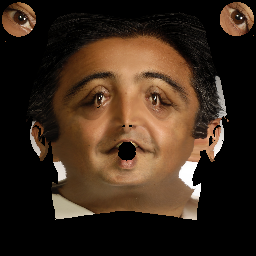

In [42]:
Image.fromarray(texture[0].permute(1, 2, 0).cpu().numpy().astype(np.uint8))

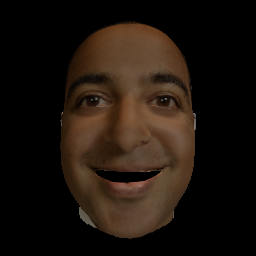

In [43]:
Image.fromarray(face[0].permute(1, 2, 0).cpu().numpy().astype(np.uint8))

In [44]:
packing_list = [i[j] for i, j in zip(textures_uv.verts_uvs_list(), textures_uv.faces_uvs_list())]
faces_verts_uvs = torch.cat(packing_list)
pixel_uvs = interpolate_face_attributes(fragments.pix_to_face, fragments.bary_coords, faces_verts_uvs)


In [47]:
pixel_uvs.shape

torch.Size([1, 256, 256, 1, 2])

In [58]:
new_texture = torch.zeros(size=(cfg["batch_size"], cfg["num_channels"], cfg["texture_size"], cfg["texture_size"]))

In [59]:
for sample_idx in range(cfg["batch_size"]):
    for y in range(cfg["image_size"]):
        for x in range(cfg["image_size"]):
            u = cfg["texture_size"] - int(pixel_uvs[sample_idx, y, x, 0, 0] * 255) - 1
            v = cfg["texture_size"] - int(pixel_uvs[sample_idx, y, x, 0, 1] * 255) - 1
            new_texture[sample_idx, :, v, u] = face[sample_idx, :, y, x]



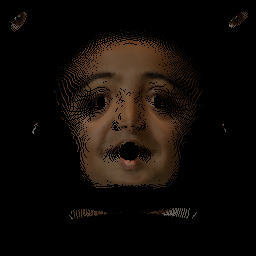

In [60]:
Image.fromarray(new_texture[0].permute(1, 2, 0).cpu().numpy().astype(np.uint8))

In [61]:
import torch.nn.functional as F


N = cfg["batch_size"]
K = 1
H_in = cfg["texture_size"]
W_in = cfg["texture_size"]
H_out = cfg["texture_size"]
W_out = cfg["texture_size"]
C = cfg["num_channels"]

pixel_uvs = pixel_uvs.permute(0, 3, 1, 2, 4).reshape(N * K, H_out, W_out, 2)

# textures.map:
#   (N, H, W, C) -> (N, C, H, W) -> (1, N, C, H, W)
#   -> expand (K, N, C, H, W) -> reshape (N*K, C, H, W)
new_texture = (
    new_texture.permute(0, 3, 1, 2)[None, ...]
    .expand(K, -1, -1, -1, -1)
    .transpose(0, 1)
    .reshape(N * K, C, H_in, W_in)
)

# Textures: (N*K, C, H, W), pixel_uvs: (N*K, H, W, 2)
# Now need to format the pixel uvs and the texture map correctly!
# From pytorch docs, grid_sample takes `grid` and `input`:
#   grid specifies the sampling pixel locations normalized by
#   the input spatial dimensions It should have most
#   values in the range of [-1, 1]. Values x = -1, y = -1
#   is the left-top pixel of input, and values x = 1, y = 1 is the
#   right-bottom pixel of input.

pixel_uvs = pixel_uvs * 2.0 - 1.0

new_texture = torch.flip(new_texture, [2])  # flip y axis of the texture map
if new_texture.device != pixel_uvs.device:
    new_texture = new_texture.to(pixel_uvs.device)
texels = F.grid_sample(
    new_texture,
    pixel_uvs,
    mode=textures_uv.sampling_mode,
    align_corners=textures_uv.align_corners,
    padding_mode=textures_uv.padding_mode,
)
# texels now has shape (NK, C, H_out, W_out)
texels = texels.reshape(N, K, C, H_out, W_out).permute(0, 3, 4, 1, 2)
texels = texels[:, :, :, 0, :]


In [62]:
texels.shape

torch.Size([1, 256, 256, 1, 3])

In [5]:
cfg = {
    "image_size": 256,
    "obj_path": "../assets/40044.obj",
    "device": "cuda",
    "elev_azimuth_random": False,
    "batch_size": 1,
    "num_channels": 3,
    "texture_size": 256,
    "render_mode": "3d",
    "add_noise": "texture_and_background"
}

In [6]:
import torch
import numpy as np
from pytorch3d.io import load_obj
from pytorch3d.renderer.mesh import Textures
from pytorch3d.structures import Meshes
from pytorch3d.renderer.mesh.shader import ShaderBase
from pytorch3d.renderer.mesh.rasterizer import Fragments
from pytorch3d.renderer.mesh.shading import phong_shading
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras,
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer
)


class HardPhongShader(ShaderBase):
    """
    Per pixel lighting - the lighting model is applied using the interpolated
    coordinates and normals for each pixel. The blending function hard assigns
    the color of the closest face for each pixel.
    To use the default values, simply initialize the shader with the desired
    device e.g.
    .. code-block::
        shader = HardPhongShader(device=torch.device("cuda:0"))
    """
    def __init__(self, backgrounds, *args, **kwargs):
        self.backgrounds = backgrounds
        super().__init__(*args, **kwargs)
    
    def _hard_rgb_blend(self, colors: torch.Tensor, backgrounds: torch.Tensor, fragments: torch.Tensor) -> torch.Tensor:
        """
        Naive blending of top K faces to return an RGBA image
        - **RGB** - choose color of the closest point i.e. K=0
        - **A** - 1.0

        Args:
            colors: (N, H, W, K, 3) RGB color for each of the top K faces per pixel.
            fragments: the outputs of rasterization. From this we use
                - pix_to_face: LongTensor of shape (N, H, W, K) specifying the indices
                of the faces (in the packed representation) which
                overlap each pixel in the image. This is used to
                determine the output shape.
            blend_params: BlendParams instance that contains a background_color
            field specifying the color for the background
        Returns:
            RGBA pixel_colors: (N, H, W, 4)
        """

        # Mask for the background.
        is_background = (fragments.pix_to_face[..., 0] < 0)
        mask = is_background.unsqueeze(-1).repeat(1, 1, 1, 3)  # (N, H, W, 3)
        pixel_colors = torch.where(mask, backgrounds, colors[..., 0, :])
        # Concat with the alpha channel.
        alpha = (~is_background).type_as(pixel_colors)[..., None]
        return torch.cat([pixel_colors, alpha], dim=-1)  # (N, H, W, 4)

    def forward(self, fragments: Fragments, meshes: Meshes, **kwargs) -> torch.Tensor:
        cameras = kwargs.get("cameras", self.cameras)
        texels = meshes.sample_textures(fragments)
        lights = kwargs.get("lights", self.lights)
        materials = kwargs.get("materials", self.materials)
        backgrounds = kwargs.get("backgrounds", self.backgrounds)
        colors = phong_shading(
            meshes=meshes,
            fragments=fragments,
            texels=texels,
            lights=lights,
            cameras=cameras,
            materials=materials,
        )
        images = self._hard_rgb_blend(colors, backgrounds, fragments)
        return images, fragments


class Renderer(object):
    def __init__(self, cfg):
        self.cfg = cfg
        self.raster_settings = RasterizationSettings(
            image_size=cfg["image_size"],
            blur_radius=0.0,
            bin_size=0,
        )
        obj_path = self.cfg["obj_path"]
        self.verts, self.faces, self.aux = load_obj(obj_path, device=self.cfg["device"])
        self.verts_uvs = self.aux.verts_uvs[None, ...]  # (1, V, 2)
        self.faces_uvs = self.faces.textures_idx[None, ...]  # (1, F, 3)

        if self.cfg['render_mode'] in ["2d", "2d_modified", "background"]:
            self.render = self._render_2d
        elif self.cfg['render_mode'] == "3d":
            self.render = self._render_3d
        else:
            raise Exception(f"Not a valid render_mode {self.cfg['render_mode']}.")
    
    def get_random_elev_azimuth(self):
        if self.cfg["elev_azimuth_random"]:
            elev = np.random.random() * 30 - 60
            azimuth = np.random.random() * 30 - 60
        else:
            elev = 0.0
            azimuth = 0.0
        return elev, azimuth
    
    def _get_foreground_mask(self, elev, azimuth):
        cfg = self.cfg
        texture = torch.ones(size=(cfg["batch_size"], cfg["num_channels"], cfg["texture_size"], cfg["texture_size"]), device=cfg["device"])
        background = torch.zeros(size=(cfg["batch_size"], cfg["num_channels"], cfg["image_size"], cfg["image_size"]), device=cfg["device"])
        face = self._render_3d(texture=texture, background=background, elev=elev, azimuth=azimuth, return_face_mean=True, j=None, rsde=None, vec_t=None, z=None, noise_face=None, step_size_face=None)
        foreground_mask = (face > 0)
        return foreground_mask
    
    def _predict_helper(self, face, rsde, vec_t, z):
        f, G = rsde.discretize(face.detach(), vec_t)
        face = face - f
        face = face + G[:, None, None, None] * z
        return face

    def _predict(self, face, j, rsde, vec_t, z):
        if self.cfg["predict"] == "face_once":
            if j == self.cfg["num_corrector_steps"] - 1:
                face = self._predict_helper(face, rsde, vec_t, z)
                return face
            else:
                return face
        elif self.cfg["predict"] == "face_always":
            face = self._predict_helper(face, rsde, vec_t, z)
            return face
        elif self.cfg["predict"] in ["never", "texture_and_background"]:
            return face
        else:
            raise Exception(f"Not a valid predict {self.cfg['predict']}.")
    
    def _add_noise(self, face, noise_face, step_size_face):
        if self.cfg["add_noise"] == "face":
            face = face + torch.sqrt(step_size_face * 2)[:, None, None, None] * noise_face * self.cfg["face_noise_coefficient"]
            return face
        else:
            return face
    
    def _render_2d(self, texture, background, elev, azimuth, return_face_mean, j, rsde, vec_t, z, noise_face, step_size_face):
        """
            Inputs:
                texture: torch.tensor with shape (N, C, H, W)
                background: torch.tensor with shape (N, C, H, W)
                elev: float
                azimuth: float
                return_face_mean: bool
                j: int
                rsde: RSDE
                vec_t : torch.Tensor
                z: torch.Tensor
                noise_face: torch.Tensor
                step_size_face: torch.Tensor
            Outputs:
                face: (N, C, H, W)
        """
        foreground_mask = self._get_foreground_mask(elev, azimuth)
        if self.cfg["render_mode"] == "background":
            face = background
        elif self.cfg["render_mode"] == "2d_modified":
            face = torch.where(foreground_mask, texture * 100, background)
        elif self.cfg["render_mode"] == "2d":
            face = torch.where(foreground_mask, texture, background)
        else:
            raise Exception(f"Not a a valid render_mode {self.cfg['render_mode']}.")
        
        if return_face_mean:
            return face
        else:
            face = self._predict(face, j, rsde, vec_t, z)
            face = self._add_noise(face, noise_face, step_size_face)
            return face

    def _render_3d(self, texture, background, elev, azimuth, return_face_mean, j, rsde, vec_t, z, noise_face, step_size_face):
        """
            Inputs:
                texture: torch.tensor with shape (N, C, H, W)
                background: torch.tensor with shape (N, C, H, W)
                elev: float
                azimuth: float
                return_face_mean: bool
                j: int
                rsde: RSDE
                vec_t : torch.Tensor
                z: torch.Tensor
                noise_face: torch.Tensor
                step_size_face: torch.Tensor
            Outputs:
                face: (N, C, H, W)
        """
        tex = Textures(verts_uvs=self.verts_uvs, faces_uvs=self.faces_uvs, maps=texture.permute(0, 2, 3, 1))

        meshes = Meshes(verts=[self.verts], faces=[self.faces.verts_idx], textures=tex)
        verts_packed = meshes.verts_packed()
        center = verts_packed.mean(0)
        scale = max((verts_packed - center).abs().max(0)[0])
        meshes.offset_verts_(-center)
        meshes.scale_verts_((1.0 / float(scale)))
        R, T = look_at_view_transform(1.0, elev, azimuth)
        cameras = FoVPerspectiveCameras(R=R, T=T, device=self.cfg["device"])
        renderer = MeshRenderer(
            rasterizer=MeshRasterizer(
                cameras=cameras, 
                raster_settings=self.raster_settings
            ),
            shader=HardPhongShader(
                device=self.cfg["device"], 
                cameras=cameras,
                backgrounds=background.permute(0, 2, 3, 1)
            )
        )
        face = renderer(meshes)[:, :, :, :3].permute(0, 3, 1, 2)  # (N, H, W, C) -> (N, C, H, W)
        if return_face_mean:
            return face
        else:
            face = self._predict(face, j, rsde, vec_t, z)
            face = self._add_noise(face, noise_face, step_size_face)
            return face


In [7]:
import torch
from pytorch3d.io import load_obj

obj_path = "../assets/40044.obj"

verts, faces, aux = load_obj(obj_path, device="cuda")
verts_uvs = aux.verts_uvs[None, ...]  # (1, V, 2)
faces_uvs = faces.textures_idx[None, ...]  # (1, F, 3)

texture = torch.randn(size=(1, 3, 256, 256), device="cuda")
background = torch.zeros(size=(1, 3, 256, 256), device="cuda")

renderer = Renderer(cfg=cfg)



An exception occurred in telemetry logging.Disabling telemetry to prevent further exceptions.
Traceback (most recent call last):
  File "/local/home/aarslan/miniconda3/envs/score_face/lib/python3.9/site-packages/iopath/common/file_io.py", line 946, in __log_tmetry_keys
    handler.log_event()
  File "/local/home/aarslan/miniconda3/envs/score_face/lib/python3.9/site-packages/iopath/common/event_logger.py", line 97, in log_event
    del self._evt
AttributeError: _evt
/local/home/aarslan/miniconda3/envs/score_face/lib/python3.9/site-packages/pytorch3d/io/utils.py:66: UserWarning: Faces have invalid indices
  warnings.warn("Faces have invalid indices")
An exception occurred in telemetry logging.Disabling telemetry to prevent further exceptions.
Traceback (most recent call last):
  File "/local/home/aarslan/miniconda3/envs/score_face/lib/python3.9/site-packages/iopath/common/file_io.py", line 946, in __log_tmetry_keys
    handler.log_event()
  File "/local/home/aarslan/miniconda3/envs/score

In [ ]:
renderer.render()

In [ ]:
from pytorch3d.ops import interpolate_face_attributes



In [1]:
import torch
import numpy as np
from pytorch3d.io import load_obj
from pytorch3d.renderer.mesh import Textures
from pytorch3d.structures import Meshes
from pytorch3d.renderer.mesh.shader import ShaderBase
from pytorch3d.renderer.mesh.rasterizer import Fragments
from pytorch3d.renderer.mesh.shading import phong_shading
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras,
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer
)


class HardPhongShader(ShaderBase):
    """
    Per pixel lighting - the lighting model is applied using the interpolated
    coordinates and normals for each pixel. The blending function hard assigns
    the color of the closest face for each pixel.
    To use the default values, simply initialize the shader with the desired
    device e.g.
    .. code-block::
        shader = HardPhongShader(device=torch.device("cuda:0"))
    """
    def __init__(self, backgrounds, *args, **kwargs):
        self.backgrounds = backgrounds
        super().__init__(*args, **kwargs)
    
    def _hard_rgb_blend(self, colors: torch.Tensor, backgrounds: torch.Tensor, fragments: torch.Tensor) -> torch.Tensor:
        """
        Naive blending of top K faces to return an RGBA image
        - **RGB** - choose color of the closest point i.e. K=0
        - **A** - 1.0

        Args:
            colors: (N, H, W, K, 3) RGB color for each of the top K faces per pixel.
            fragments: the outputs of rasterization. From this we use
                - pix_to_face: LongTensor of shape (N, H, W, K) specifying the indices
                of the faces (in the packed representation) which
                overlap each pixel in the image. This is used to
                determine the output shape.
            blend_params: BlendParams instance that contains a background_color
            field specifying the color for the background
        Returns:
            RGBA pixel_colors: (N, H, W, 4)
        """

        # Mask for the background.
        is_background = (fragments.pix_to_face[..., 0] < 0)
        mask = is_background.unsqueeze(-1).repeat(1, 1, 1, 3)  # (N, H, W, 3)
        pixel_colors = torch.where(mask, backgrounds, colors[..., 0, :])
        # Concat with the alpha channel.
        alpha = (~is_background).type_as(pixel_colors)[..., None]
        return torch.cat([pixel_colors, alpha], dim=-1)  # (N, H, W, 4)

    def forward(self, fragments: Fragments, meshes: Meshes, **kwargs) -> torch.Tensor:
        cameras = kwargs.get("cameras", self.cameras)
        texels = meshes.sample_textures(fragments)
        lights = kwargs.get("lights", self.lights)
        materials = kwargs.get("materials", self.materials)
        backgrounds = kwargs.get("backgrounds", self.backgrounds)
        colors = phong_shading(
            meshes=meshes,
            fragments=fragments,
            texels=texels,
            lights=lights,
            cameras=cameras,
            materials=materials,
        )
        images = self._hard_rgb_blend(colors, backgrounds, fragments)
        return images, fragments


class Renderer(object):
    def __init__(self, cfg):
        self.cfg = cfg
        self.raster_settings = RasterizationSettings(
            image_size=cfg["image_size"],
            blur_radius=0.0,
            bin_size=0,
        )
        obj_path = self.cfg["obj_path"]
        self.verts, self.faces, self.aux = load_obj(obj_path, device=self.cfg["device"])
        self.verts_uvs = self.aux.verts_uvs[None, ...]  # (1, V, 2)
        self.faces_uvs = self.faces.textures_idx[None, ...]  # (1, F, 3)

        if self.cfg['render_mode'] in ["2d", "2d_modified", "background"]:
            self.render = self._render_2d
        elif self.cfg['render_mode'] == "3d":
            self.render = self._render_3d
        else:
            raise Exception(f"Not a valid render_mode {self.cfg['render_mode']}.")
    
    def get_random_elev_azimuth(self):
        if self.cfg["elev_azimuth_random"]:
            elev = np.random.random() * 30 - 60
            azimuth = np.random.random() * 30 - 60
        else:
            elev = 0.0
            azimuth = 0.0
        return elev, azimuth
    
    def _get_foreground_mask(self, elev, azimuth):
        cfg = self.cfg
        texture = torch.ones(size=(cfg["batch_size"], cfg["num_channels"], cfg["texture_size"], cfg["texture_size"]), device=cfg["device"])
        background = torch.zeros(size=(cfg["batch_size"], cfg["num_channels"], cfg["image_size"], cfg["image_size"]), device=cfg["device"])
        face = self._render_3d(texture=texture, background=background, elev=elev, azimuth=azimuth, return_face_mean=True, j=None, rsde=None, vec_t=None, z=None, noise_face=None, step_size_face=None)
        foreground_mask = (face > 0)
        return foreground_mask
    
    def _predict_helper(self, face, rsde, vec_t, z):
        f, G = rsde.discretize(face.detach(), vec_t)
        face = face - f
        face = face + G[:, None, None, None] * z
        return face

    def _predict(self, face, j, rsde, vec_t, z):
        if self.cfg["predict"] == "face_once":
            if j == self.cfg["num_corrector_steps"] - 1:
                face = self._predict_helper(face, rsde, vec_t, z)
                return face
            else:
                return face
        elif self.cfg["predict"] == "face_always":
            face = self._predict_helper(face, rsde, vec_t, z)
            return face
        elif self.cfg["predict"] in ["never", "texture_and_background"]:
            return face
        else:
            raise Exception(f"Not a valid predict {self.cfg['predict']}.")
    
    def _add_noise(self, face, noise_face, step_size_face):
        if self.cfg["add_noise"] == "face":
            face = face + torch.sqrt(step_size_face * 2)[:, None, None, None] * noise_face * self.cfg["face_noise_coefficient"]
            return face
        else:
            return face
    
    def _render_2d(self, texture, background, elev, azimuth, return_face_mean, j, rsde, vec_t, z, noise_face, step_size_face):
        """
            Inputs:
                texture: torch.tensor with shape (N, C, H, W)
                background: torch.tensor with shape (N, C, H, W)
                elev: float
                azimuth: float
                return_face_mean: bool
                j: int
                rsde: RSDE
                vec_t : torch.Tensor
                z: torch.Tensor
                noise_face: torch.Tensor
                step_size_face: torch.Tensor
            Outputs:
                face: (N, C, H, W)
        """
        foreground_mask = self._get_foreground_mask(elev, azimuth)
        if self.cfg["render_mode"] == "background":
            face = background
        elif self.cfg["render_mode"] == "2d_modified":
            face = torch.where(foreground_mask, texture * 100, background)
        elif self.cfg["render_mode"] == "2d":
            face = torch.where(foreground_mask, texture, background)
        else:
            raise Exception(f"Not a a valid render_mode {self.cfg['render_mode']}.")
        
        if return_face_mean:
            return face
        else:
            face = self._predict(face, j, rsde, vec_t, z)
            face = self._add_noise(face, noise_face, step_size_face)
            return face

    def _render_3d(self, texture, background, elev, azimuth, return_face_mean, j, rsde, vec_t, z, noise_face, step_size_face):
        """
            Inputs:
                texture: torch.tensor with shape (N, C, H, W)
                background: torch.tensor with shape (N, C, H, W)
                elev: float
                azimuth: float
                return_face_mean: bool
                j: int
                rsde: RSDE
                vec_t : torch.Tensor
                z: torch.Tensor
                noise_face: torch.Tensor
                step_size_face: torch.Tensor
            Outputs:
                face: (N, C, H, W)
        """
        tex = Textures(verts_uvs=self.verts_uvs, faces_uvs=self.faces_uvs, maps=texture.permute(0, 2, 3, 1))

        meshes = Meshes(verts=[self.verts], faces=[self.faces.verts_idx], textures=tex)
        verts_packed = meshes.verts_packed()
        center = verts_packed.mean(0)
        scale = max((verts_packed - center).abs().max(0)[0])
        meshes.offset_verts_(-center)
        meshes.scale_verts_((1.0 / float(scale)))
        R, T = look_at_view_transform(1.0, elev, azimuth)
        cameras = FoVPerspectiveCameras(R=R, T=T, device=self.cfg["device"])
        renderer = MeshRenderer(
            rasterizer=MeshRasterizer(
                cameras=cameras, 
                raster_settings=self.raster_settings
            ),
            shader=HardPhongShader(
                device=self.cfg["device"], 
                cameras=cameras,
                backgrounds=background.permute(0, 2, 3, 1)
            )
        )
        face = renderer(meshes)[:, :, :, :3].permute(0, 3, 1, 2)  # (N, H, W, C) -> (N, C, H, W)
        if return_face_mean:
            return face
        else:
            face = self._predict(face, j, rsde, vec_t, z)
            face = self._add_noise(face, noise_face, step_size_face)
            return face


/local/home/aarslan/miniconda3/envs/score_face/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
obj_path = "../assets/20705.obj"

verts, faces, aux = load_obj(obj_path, device="cuda")
verts_uvs = aux.verts_uvs[None, ...]  # (1, V, 2)
faces_uvs = faces.textures_idx[None, ...]  # (1, F, 3)

texture = torch.randn(size=(1, 3, 256, 256), device="cuda")

tex = Textures(verts_uvs=verts_uvs, faces_uvs=faces_uvs, maps=texture.permute(0, 2, 3, 1))


An exception occurred in telemetry logging.Disabling telemetry to prevent further exceptions.
Traceback (most recent call last):
  File "/local/home/aarslan/miniconda3/envs/score_face/lib/python3.9/site-packages/iopath/common/file_io.py", line 946, in __log_tmetry_keys
    handler.log_event()
  File "/local/home/aarslan/miniconda3/envs/score_face/lib/python3.9/site-packages/iopath/common/event_logger.py", line 97, in log_event
    del self._evt
AttributeError: _evt
/local/home/aarslan/miniconda3/envs/score_face/lib/python3.9/site-packages/pytorch3d/io/utils.py:66: UserWarning: Faces have invalid indices
  warnings.warn("Faces have invalid indices")


In [4]:

packing_list = [
    i[j] for i, j in zip(verts_uvs, self.faces_uvs_list())
]
faces_verts_uvs = torch.cat(packing_list)
new_texture = self.maps_padded()

# pixel_uvs: (N, H, W, K, 2)
pixel_uvs = interpolate_face_attributes(
    fragments.pix_to_face, fragments.bary_coords, faces_verts_uvs
)

N, H_out, W_out, K = fragments.pix_to_face.shape
N, H_in, W_in, C = texture_maps.shape  # 3 for RGB

# pixel_uvs: (N, H, W, K, 2) -> (N, K, H, W, 2) -> (NK, H, W, 2)
pixel_uvs = pixel_uvs.permute(0, 3, 1, 2, 4).reshape(N * K, H_out, W_out, 2)